# LSTM Model for Urban Sound Classification

## Installing Required Libraries

In [ ]:
!pip install librosa

In [ ]:
!pip install tensorflow

In [ ]:
!pip install matplotlib

In [ ]:
!pip install pandas

In [ ]:
!pip install tqdm

In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install seaborn

## Importing Required Dependencies

In [ ]:
# Standard Libraries
import os
from collections import Counter
import IPython.display as ipd
import random

# Data Handling Libraries
import numpy as np
import pandas as pd

# ML / Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Deep Learning Libraries (Tensorflow/Keras)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Reproducibility (best-effort)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [ ]:
# ===== Load preprocessed dataset produced by GRU =====
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

CSV_PATH = '../augmented_normal_data.csv'
df = pd.read_csv(CSV_PATH)
print("Loaded:", CSV_PATH, "| shape:", df.shape)

# --- Features & labels ---
if 'label' in df.columns:
    feature_cols = [c for c in df.columns if c != 'label']
    X = df[feature_cols].values                    # (N, F)   <-- F inferred automatically (here F=128)
    y = pd.get_dummies(df['label'], dtype=int).values  # (N, 10) one-hot
    class_names = list(pd.get_dummies(df['label']).columns)
else:
    # If there is NO 'label' column and last 10 cols are one-hot labels:
    X = df.iloc[:, :-10].values
    y = df.iloc[:, -10:].values
    class_names = list(df.columns[-10:])

F = X.shape[1]
num_classes = y.shape[1]
print(f"Detected feature dimension F={F}, num_classes={num_classes}")

# Basic sanity checks (now generic, not hard-coded to 40)
assert y.ndim == 2 and num_classes == 10, f"Expected one-hot with 10 classes, got {y.shape}"

# Split (no SMOTE/Scaler here)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=np.argmax(y, axis=1)
)

# Reshape for RNNs: (N, time_steps=1, features=F)
X_train = X_train.reshape((X_train.shape[0], 1, F))
X_test  = X_test.reshape((X_test.shape[0],  1, F))

input_shape = (1, F)
output_units = num_classes

print("X_train:", X_train.shape, "X_test:", X_test.shape,
      "y_train:", y_train.shape, "y_test:", y_test.shape)
print("Classes:", class_names)


Loaded: ./augmented_normal_data.csv | shape: (43660, 129)
Detected feature dimension F=128, num_classes=10
X_train: (34928, 1, 128) X_test: (8732, 1, 128) y_train: (34928, 10) y_test: (8732, 10)
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
class LSTMHyperModel(kt.HyperModel):
    def __init__(self, input_shape, output_units):
        self.input_shape = input_shape
        self.output_units = output_units

    def build(self, hp):
        model = Sequential()

        # First LSTM layer
        model.add(LSTM(
            units=hp.Int('units_layer1', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_layer1', values=['relu', 'tanh', 'sigmoid']),
            input_shape=self.input_shape,
            return_sequences=True
        ))
        model.add(Dropout(hp.Float('dropout_layer1', min_value=0.0, max_value=0.5, step=0.1)))

        # Second LSTM layer
        model.add(LSTM(
            units=hp.Int('units_layer2', min_value=32, max_value=512, step=32),
            activation=hp.Choice('activation_layer2', values=['relu', 'tanh', 'sigmoid']),
            return_sequences=False
        ))
        model.add(Dropout(hp.Float('dropout_layer2', min_value=0.0, max_value=0.5, step=0.1)))

        # Output layer
        model.add(Dense(self.output_units, activation='softmax'))

        # Compile
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
possible_epochs = [50, 100]

In [ ]:
# Instantiate the HyperModel
lstm_hypermodel = LSTMHyperModel(input_shape=input_shape, output_units=output_units)

In [ ]:
# Run separate tuner projects for each epoch budget (like the original)
best_models = {}
best_hparams = {}

for epoch_count in possible_epochs:
    print(f"\n=== Hyperparameter search with {epoch_count} epochs ===")

    tuner = kt.RandomSearch(
        lstm_hypermodel,
        objective='val_accuracy',
        max_trials=10,               # combinations to try
        executions_per_trial=1,      # single execution per trial
        directory='./tuner_dir_lstm',
        project_name=f'lstm_epoch_{epoch_count}',
        overwrite=False
    )

    tuner.search(
        X_train, y_train,
        epochs=epoch_count,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Store best model + params for this epoch_count
    best_models[epoch_count]  = tuner.get_best_models(num_models=1)[0]
    best_hparams[epoch_count] = tuner.get_best_hyperparameters(num_trials=1)[0]
    try:
        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
        print(f"Best val_accuracy @ {epoch_count} epochs:", best_trial.score)
    except Exception as e:
        print(f"(Could not query trial score: {e})")


Trial 10 Complete [00h 07m 46s]
val_accuracy: 0.9753793478012085

Best val_accuracy So Far: 0.9753793478012085
Total elapsed time: 01h 06m 43s
Best val_accuracy @ 100 epochs: 0.9753793478012085


In [ ]:
# Choose the best across epoch budgets by evaluating on validation during tuner (already done)
# We'll pick the one with highest tuner score; then evaluate on test set
def get_val_score(hp):
    # tuner stored the score; just return it if available
    return None  # placeholder if needed—already printed above

# Heuristic: evaluate all best models on the test set and pick the best
best_epoch = None
best_model = None
best_test_acc = -1.0

for epoch_count, m in best_models.items():
    loss, acc = m.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy (best model @ {epoch_count} epochs): {acc:.4f}")
    if acc > best_test_acc:
        best_test_acc = acc
        best_epoch = epoch_count
        best_model = m

print(f"\nSelected best model from epoch budget {best_epoch} with test acc = {best_test_acc:.4f}")

# Save hyperparameters for both epoch budgets to a small DataFrame
rows = []
for epoch_count, hp in best_hparams.items():
    row = {"Epochs": epoch_count}
    row.update(hp.values)
    rows.append(row)

hyperparameters_df = pd.DataFrame(rows)
display(hyperparameters_df)


Test accuracy (best model @ 50 epochs): 0.9642
Test accuracy (best model @ 100 epochs): 0.9751

Selected best model from epoch budget 100 with test acc = 0.9751


,Epochs,units_layer1,activation_layer1,dropout_layer1,units_layer2,activation_layer2,dropout_layer2,learning_rate
0,50,160,tanh,0.3,448,tanh,0.0,0.001
1,100,320,tanh,0.2,288,tanh,0.1,0.001


In [ ]:
# Utility to rebuild with best hyperparameters
def build_lstm_model(hp_obj, input_shape, output_units):
    """hp_obj is a keras_tuner.engine.hyperparameters.HyperParameters object."""
    model = Sequential()
    model.add(LSTM(
        units=hp_obj.get('units_layer1'),
        activation=hp_obj.get('activation_layer1'),
        input_shape=input_shape,
        return_sequences=True
    ))
    model.add(Dropout(hp_obj.get('dropout_layer1')))
    model.add(LSTM(
        units=hp_obj.get('units_layer2'),
        activation=hp_obj.get('activation_layer2'),
        return_sequences=False
    ))
    model.add(Dropout(hp_obj.get('dropout_layer2')))
    model.add(Dense(output_units, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=hp_obj.get('learning_rate')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---- pick best epoch if not already picked ----
if 'best_epoch' not in globals() or best_epoch is None:
    # fall back to "first available" epoch key
    best_epoch = sorted(best_hparams.keys())[0]

# sanity check
assert best_epoch in best_hparams, f"No hyperparameters stored for epoch budget {best_epoch}"

# grab the HyperParameters object selected above
final_hp = best_hparams[best_epoch]

# build with the correct variable (not 'best_hyperparameters')
model = build_lstm_model(final_hp, input_shape=input_shape, output_units=output_units)

history = model.fit(
    X_train, y_train,
    epochs=100,                 # early stopping will cap it
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


874/874 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4798 - loss: 1.5197 - val_accuracy: 0.6944 - val_loss: 0.9695
Epoch 2/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6930 - loss: 0.9173 - val_accuracy: 0.7544 - val_loss: 0.7641
Epoch 3/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7501 - loss: 0.7486 - val_accuracy: 0.7884 - val_loss: 0.6583
Epoch 4/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7826 - loss: 0.6494 - val_accuracy: 0.8139 - val_loss: 0.5773
Epoch 5/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8044 - loss: 0.5813 - val_accuracy: 0.8271 - val_loss: 0.5247
Epoch 6/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8199 - loss: 0.5269 - val_accuracy: 0.8372 - val_loss: 0.4830
Epoch 7/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8331 - loss: 0.4796 - val_accuracy: 0.8508 - val_loss: 0.4404
Epoch 8/100
874/874 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8468 - loss: 0.4428 - val_accuracy: 0.86

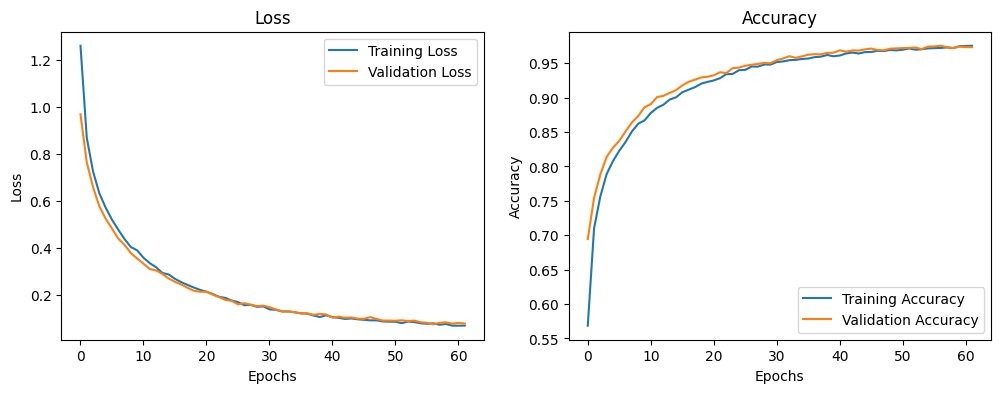

In [ ]:
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Final Test Accuracy: 0.9739 | Final Test Loss: 0.0765
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1000
           1       0.99      0.98      0.99       429
           2       0.94      0.95      0.95      1000
           3       0.98      0.96      0.97      1000
           4       0.98      0.98      0.98      1000
           5       0.98      0.99      0.98      1000
           6       0.99      0.98      0.98       374
           7       0.98      0.98      0.98      1000
           8       0.96      0.98      0.97       929
           9       0.98      0.95      0.96      1000

    accuracy                           0.97      8732
   macro avg       0.98      0.97      0.98      8732
weighted avg       0.97      0.97      0.97      8732



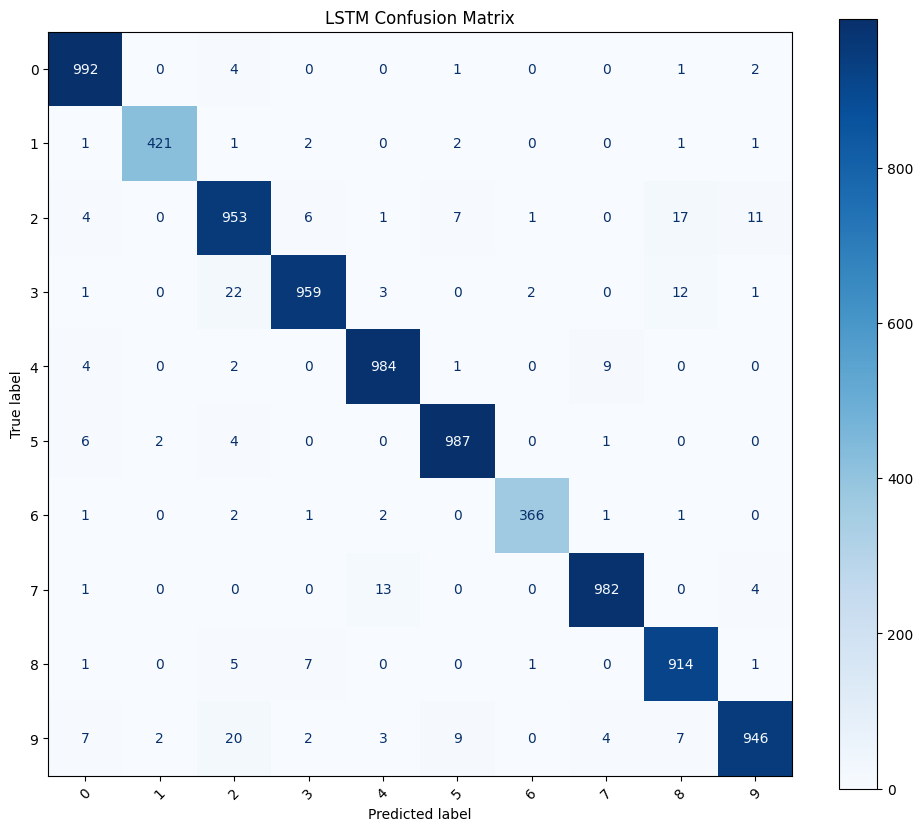

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final Test Accuracy:", round(test_acc, 4), "| Final Test Loss:", round(test_loss, 4))

# Predict
proba = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(proba, axis=-1)
y_test_classes = np.argmax(y_test, axis=-1)

# Make sure names are strings and align to the labels that actually appear
labels_present = np.unique(y_test_classes)
names_present = [str(class_names[i]) for i in labels_present]

print(classification_report(
    y_test_classes, y_pred_classes,
    labels=labels_present,
    target_names=names_present
))

# Confusion matrix (only present labels)
cm = confusion_matrix(y_test_classes, y_pred_classes, labels=labels_present)
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names_present)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)
plt.title("LSTM Confusion Matrix")
plt.show()

In [ ]:
# Save
os.makedirs('./Models', exist_ok=True)
model.save('./Models/best_lstm_model.keras', include_optimizer=False)
print("Saved to ./Models/best_lstm_model.keras (no optimizer state).")

# Summary
model.summary()


Saved to ./Models/best_lstm_model.keras (no optimizer state).


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 320)         │       574,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 320)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 288)            │       701,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,837,536 (14.64 MB)

 Trainable params: 1,279,178 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,558,358 (9.76 MB)